# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [73]:
# initial imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import panel as pn
import plotly.express as px
from pathlib import Path
from dotenv import load_dotenv

# Initialize the Panel Extensions (for Plotly)
pn.extension('plotly')

In [74]:
# Importing hvplot.pandas after pn.extension to avoid plotly initialization failure.
import hvplot.pandas

In [75]:
# Read the Mapbox API key
load_dotenv()
mapbox_api_key = os.getenv("MAPBOX_API_KEY")

# Setting token using Plotly Express set function
px.set_mapbox_access_token(mapbox_api_key)
type(mapbox_api_key)

str

# Import Data

In [76]:
# Import the CSVs to Pandas DataFrames
file_path = Path("Data/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")

file_path = Path("Data/neighborhoods_coordinates.csv")
df_neighborhood_locations = pd.read_csv(file_path)

#sfo_data.head()
#df_neighborhood_locations.head()

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [77]:
# Define Panel Visualization Functions
def housing_units_per_year():
    """Housing Units Per Year."""
    housing_units = sfo_data["housing_units"].groupby("year").mean()
    
    fig_housing_units = plt.figure()
    housing_units_plot = housing_units.plot.bar()
    plt.xlabel("Year")  
    plt.ylabel("Housing Units")
    plt.title("Housing Units in San Francisco from 2010 to 2016", fontweight="bold")

    # Optional Challenge: Use the min, max, and std to scale the y limits of the chart
    housing_units_max = max(housing_units)
    #print(housing_units_max)

    housing_units_min = min(housing_units)
    #print(housing_units_min)

    housing_units_std = housing_units.std()
    #print(housing_units_std)

    housing_units_plot.set_ylim(
    housing_units_min - housing_units_std, housing_units_max + housing_units_std)
        
    housing_units_plot = housing_units_plot.figure
    
    return housing_units_plot


def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    
    average_gross_rent = sfo_data[["sale_price_sqr_foot", "gross_rent"]].groupby("year").mean()
    
    plt.figure()
    gross_rent_plot = average_gross_rent.plot(y="gross_rent")  
    plt.xlabel("Year")  
    plt.ylabel("Gross Rent")
    plt.title("Average Gross Rent in San Francisco", fontweight="bold")
    gross_rent_plot = gross_rent_plot.figure
    
    return gross_rent_plot

def average_sales_price():
    """Average Sales Price Per Year."""
    
    average_gross_rent = sfo_data[["sale_price_sqr_foot", "gross_rent"]].groupby("year").mean()
    
    plt.figure()
    sales_price_plot = average_gross_rent.plot(y="sale_price_sqr_foot")  
    plt.xlabel("Year")  
    plt.ylabel("Average Sale Price")
    plt.title("Average Sale Price Per Square Foot in San Francisco", fontweight="bold")
    sales_price_plot = sales_price_plot.figure

    return sales_price_plot

def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    
    year_neighborhood_df = sfo_data.groupby(["year", "neighborhood"]).mean().reset_index()
    
    average_neighborhood_price = year_neighborhood_df.hvplot(x="year", xlabel="Year", 
                                                             y="sale_price_sqr_foot", 
                                                             ylabel="Avg. Sale Price per Square Foot", 
                                                             groupby="neighborhood", kind="line")
    
    return average_neighborhood_price


def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""
    
    expensive_neighborhoods = sfo_data.groupby(["neighborhood"]).mean().sort_values(
        ["sale_price_sqr_foot"], ascending=False)
    expensive_neighborhoods.reset_index(inplace=True)
    ten_expensive_neighborhoods = expensive_neighborhoods.nlargest(10, "sale_price_sqr_foot")

    top_ten_expensive = ten_expensive_neighborhoods.hvplot.bar(x="neighborhood", rot=90, height=400, 
                                        y="sale_price_sqr_foot", xlabel="Neighborhood", 
                                        ylabel="Avg. Sale Price Per Square Foot",
                                        title="Top 10 Expensive Neighborhoods in San Francisco")
    
    return top_ten_expensive


def parallel_coordinates():
    """Parallel Coordinates Plot."""
    
    expensive_neighborhoods = sfo_data.groupby(["neighborhood"]).mean().sort_values(
        ["sale_price_sqr_foot"], ascending=False)
    expensive_neighborhoods.reset_index(inplace=True)
    ten_expensive_neighborhoods = expensive_neighborhoods.nlargest(10, "sale_price_sqr_foot")
    
    parallel_coordinates_plot = px.parallel_coordinates(
        ten_expensive_neighborhoods,    
        dimensions = ["sale_price_sqr_foot", "housing_units", "gross_rent"],
        color = "sale_price_sqr_foot",
        color_continuous_scale=px.colors.sequential.Inferno,
        labels={
            "sale_price_sqr_foot":"Sales Price Sqr. Foot",
            "housing_units":"Housing Units", 
            "gross_rent":"Gross Rent" 
    }
)

    return parallel_coordinates_plot

def parallel_categories():
    """Parallel Categories Plot."""
    
    expensive_neighborhoods = sfo_data.groupby(["neighborhood"]).mean().sort_values(
        ["sale_price_sqr_foot"], ascending=False)
    expensive_neighborhoods.reset_index(inplace=True)
    ten_expensive_neighborhoods = expensive_neighborhoods.nlargest(10, "sale_price_sqr_foot")
    
    parallel_categories_plot = px.parallel_categories(
        ten_expensive_neighborhoods,    
        dimensions = ["neighborhood", "sale_price_sqr_foot", "housing_units", "gross_rent"],
        color = "sale_price_sqr_foot",
        color_continuous_scale=px.colors.sequential.Inferno,
        labels={
            "neighborhood":"Neighborhood",
            "sale_price_sqr_foot":"Sales Price Sqr. Foot",
            "housing_units":"Housing Units", 
            "gross_rent":"Gross Rent" 
    }
)

    return parallel_categories_plot

def neighborhood_map():
    """Neighborhood Map"""
    
    neighborhood_mean_values = sfo_data.groupby(["neighborhood"]).mean().reset_index()
    
    values_locations_df = pd.concat([df_neighborhood_locations, neighborhood_mean_values], 
                                    axis="columns", join="inner")
    values_locations_df.drop(columns=["neighborhood"], inplace=True)
    
    average_values_per_neighborhood = px.scatter_mapbox(
        values_locations_df, 
        lat="Lat",
        lon="Lon",
        size="sale_price_sqr_foot",
        color="gross_rent",
        color_continuous_scale=px.colors.cyclical.IceFire,
        title="Average Sale Price Per Square Foot & Gross Rent in San Francisco",
        zoom=11,
        width=1000
)

    return average_values_per_neighborhood


## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

In [78]:
# Testing all functions with interact() command.
from panel.interact import interact
from panel import widgets

#interact(average_gross_rent)

In [79]:
intro_tab = pn.Column(
    "### Real Estate Analysis of San Francisco from 2010 - 2016",
    f"This dashboard provides analysis of the San Francisco real estate market from 2010 to 2016." 
    f" It provides data on the number of housing units per year, average gross rent, average sales"
    f" price, average price by neighborhood, and the top ten most expensive neighborhoods. The tabs"
    f" above can be used to navigate the dashboard and dive into more detail of the market during the" 
    f" time period of this analysis.",
    
    neighborhood_map(), width=700
)

#intro_tab

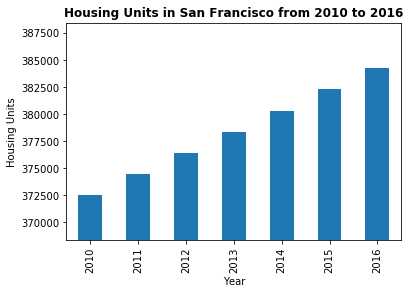

<Figure size 432x288 with 0 Axes>

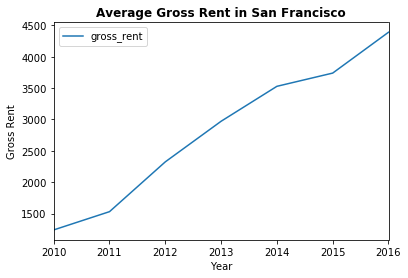

<Figure size 432x288 with 0 Axes>

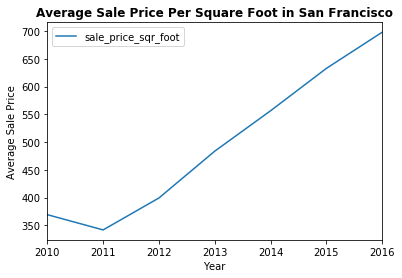

In [80]:
tab_1 = pn.Row(housing_units_per_year(), average_gross_rent(), average_sales_price())
#tab_1

In [81]:
tab_2 = pn.Column(
    "### Neighborhood Cost Trends & Ten Most Costly Neighborhoods",
    average_price_by_neighborhood(), top_most_expensive_neighborhoods()
)
#tab_2

In [82]:
tab_3 = pn.Column(
    parallel_coordinates(), 
    parallel_categories())
#tab_3

Tabs
    [0] Column(width=700)
        [0] Markdown(str)
        [1] Markdown(str)
        [2] Plotly(Figure)
    [1] Row
        [0] Matplotlib(Figure)
        [1] Matplotlib(Figure)
        [2] Matplotlib(Figure)
    [2] Column
        [0] Markdown(str)
        [1] Row
            [0] HoloViews(DynamicMap)
            [1] Column
                [0] WidgetBox
                    [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                [1] VSpacer()
        [2] HoloViews(Bars)
    [3] Column
        [0] Plotly(Figure)
        [1] Plotly(Figure)
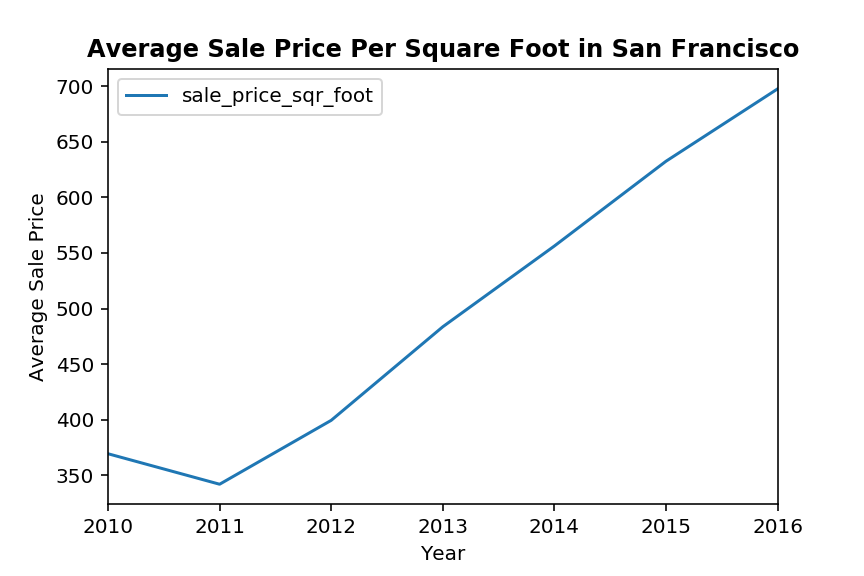
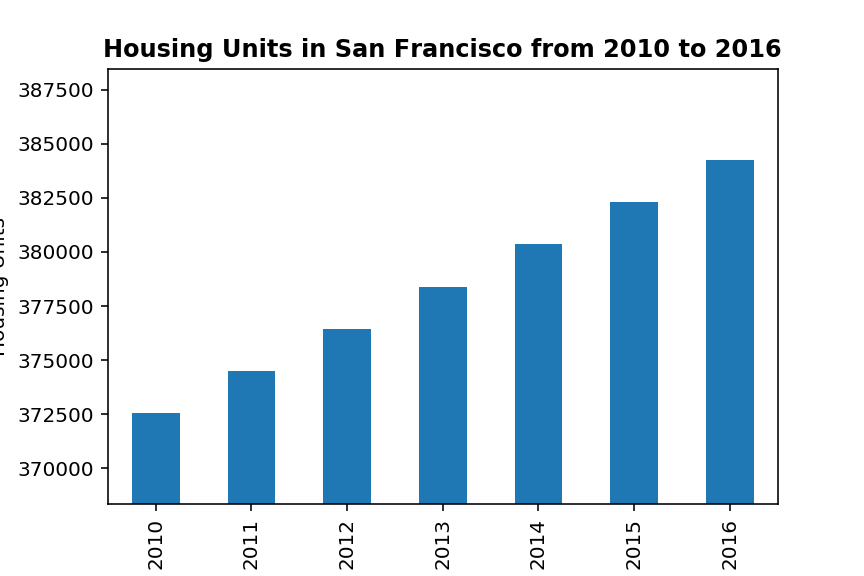
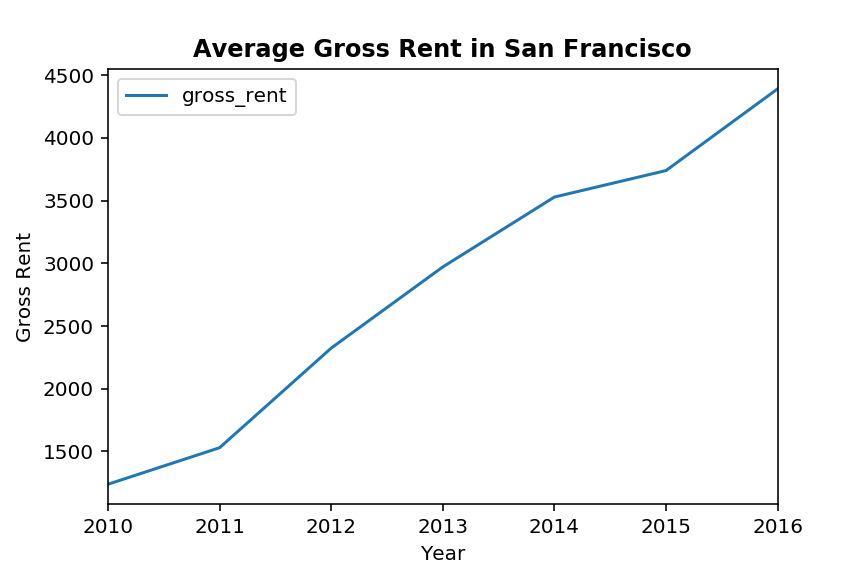

In [83]:
dashboard_tabs = pn.Tabs(
    ("Intro Analysis", intro_tab),
    ("Yearly Market Analysis", tab_1),
    ("Neighborhood Analysis", tab_2),
    ("Parallel Plots Analysis", tab_3),
)
dashboard_tabs

## Serve the Panel Dashboard

Tabs
    [0] Column(width=700)
        [0] Markdown(str)
        [1] Markdown(str)
        [2] Plotly(Figure)
    [1] Row
        [0] Matplotlib(Figure)
        [1] Matplotlib(Figure)
        [2] Matplotlib(Figure)
    [2] Column
        [0] Markdown(str)
        [1] Row
            [0] HoloViews(DynamicMap)
            [1] Column
                [0] WidgetBox
                    [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                [1] VSpacer()
        [2] HoloViews(Bars)
    [3] Column
        [0] Plotly(Figure)
        [1] Plotly(Figure)
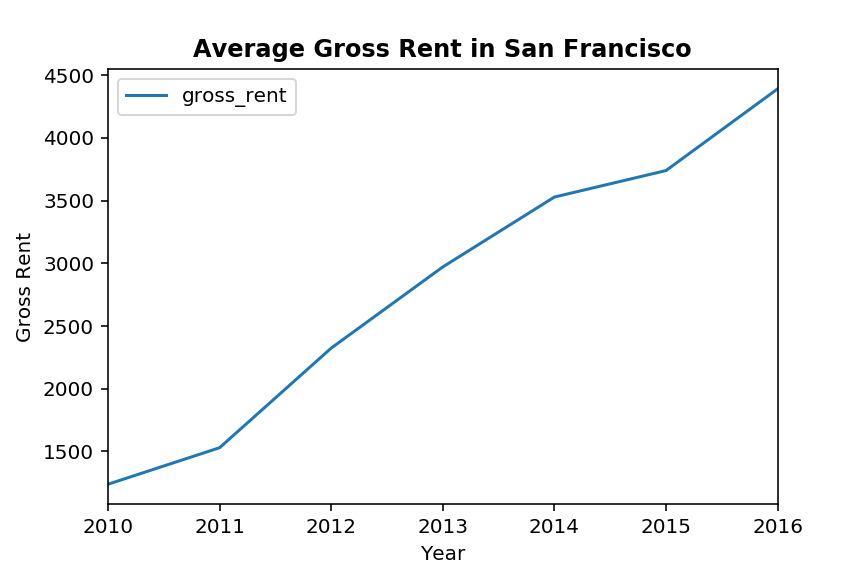
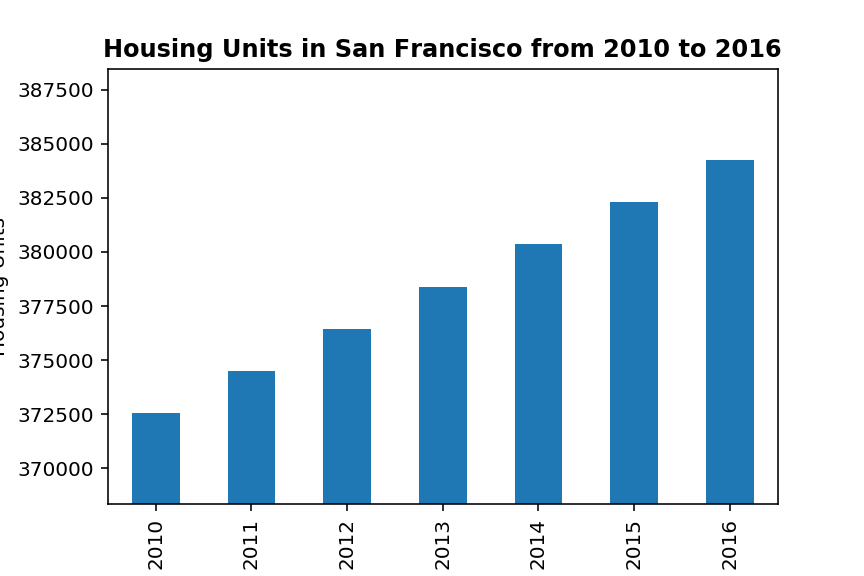
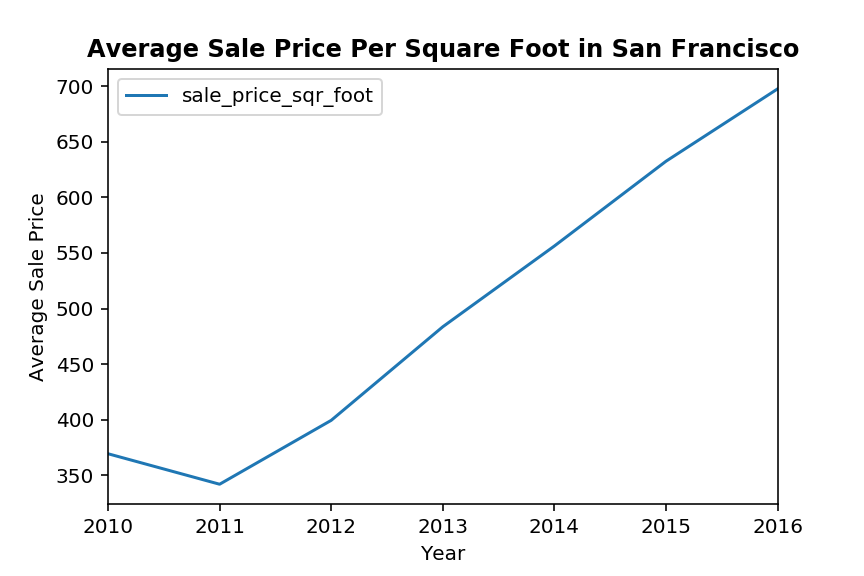

In [84]:
dashboard_tabs.servable()